In [1]:
import numpy
import pandas
import seaborn

import tqdm.notebook as tqdm

from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import SGDClassifier

from matplotlib import pyplot

from itertools import chain, combinations

In [2]:
seaborn.set(rc={'figure.figsize':(11.7, 8.27)})

Lendo a tabela de dados:

In [3]:
dataframe = pandas.read_csv('./abalone_dataset.csv', sep=',')
dataframe

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,type
0,M,0.535,0.420,0.150,0.6995,0.2575,0.1530,0.2400,3
1,I,0.510,0.380,0.115,0.5155,0.2150,0.1135,0.1660,1
2,I,0.185,0.130,0.045,0.0290,0.0120,0.0075,0.0095,1
3,M,0.550,0.450,0.170,0.8100,0.3170,0.1570,0.2200,3
4,I,0.535,0.415,0.150,0.5765,0.3595,0.1350,0.2250,1
...,...,...,...,...,...,...,...,...,...
3127,F,0.545,0.405,0.175,0.9800,0.2585,0.2070,0.3800,3
3128,M,0.655,0.525,0.185,1.2590,0.4870,0.2215,0.4450,3
3129,I,0.450,0.340,0.120,0.4925,0.2410,0.1075,0.1200,1
3130,F,0.520,0.410,0.155,0.7270,0.2910,0.1835,0.2350,3


Resumo dos dados:

In [4]:
dataframe_desc = dataframe.describe()
dataframe_desc

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,type
count,3132.000000,3132.000000,3132.000000,3132.000000,3132.000000,3132.000000,3132.000000,3132.000000
mean,0.521392,0.405865,0.138263,0.818738,0.355398,0.178349,0.235616,1.991379
std,0.120756,0.099600,0.039206,0.489560,0.221473,0.109554,0.139215,0.824561
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.345000,0.110000,0.436375,0.181500,0.090875,0.127500,1.000000
50%,0.540000,0.420000,0.140000,0.787000,0.330500,0.168000,0.225000,2.000000
75%,0.610000,0.480000,0.165000,1.141625,0.497500,0.250125,0.323625,3.000000
max,0.815000,0.650000,0.515000,2.825500,1.488000,0.760000,1.005000,3.000000


Vamos separar o dataframe por classe e retirar os _outliers_ de cada grupo.

In [5]:
dataframe1 = dataframe[dataframe.type == 1]
dataframe2 = dataframe[dataframe.type == 2]
dataframe3 = dataframe[dataframe.type == 3]

In [6]:
def remove_outliers(df, feature, iqr=1.5):
    
    desc = df.describe()
    
    q1 = desc[feature]['25%']
    q3 = desc[feature]['75%']
    
    not_outliers = df[feature].apply(lambda value: q1 - iqr * (q3 - q1) <= value <= q3 + iqr * (q3 - q1))
    
    return df[not_outliers].reset_index(drop=True)

In [7]:
dataframes = []

for dataframei in [dataframe1, dataframe2, dataframe3]:
    dataframei_ = dataframei.copy()

    for col in dataframei_.columns.drop(['sex', 'type']):
        dataframei_ = remove_outliers(df=dataframei_, feature=col)
        
    dataframes.append(dataframei_)

In [8]:
dataframe_ = pandas.concat(dataframes, ignore_index=True)
dataframe_

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,type
0,I,0.510,0.380,0.115,0.5155,0.2150,0.1135,0.1660,1
1,I,0.185,0.130,0.045,0.0290,0.0120,0.0075,0.0095,1
2,I,0.535,0.415,0.150,0.5765,0.3595,0.1350,0.2250,1
3,I,0.380,0.290,0.100,0.2370,0.1080,0.0395,0.0820,1
4,I,0.430,0.330,0.100,0.4490,0.2540,0.0825,0.0970,1
...,...,...,...,...,...,...,...,...,...
2960,F,0.550,0.410,0.145,0.8285,0.3095,0.1905,0.2500,3
2961,M,0.490,0.420,0.125,0.6090,0.2390,0.1435,0.2200,3
2962,F,0.545,0.405,0.175,0.9800,0.2585,0.2070,0.3800,3
2963,M,0.655,0.525,0.185,1.2590,0.4870,0.2215,0.4450,3


Comparando os dataframes:

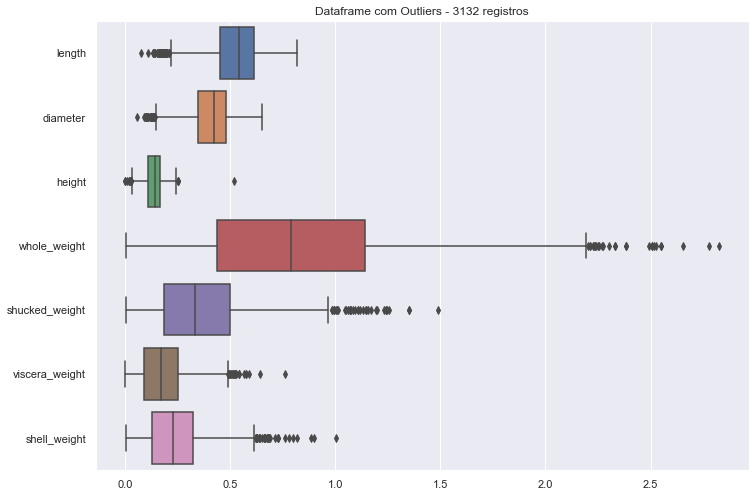

In [9]:
seaborn.boxplot(data=dataframe[dataframe.columns.drop(['type'])], orient='h')
p = pyplot.title('Dataframe com Outliers - %d registros' % dataframe.shape[0])

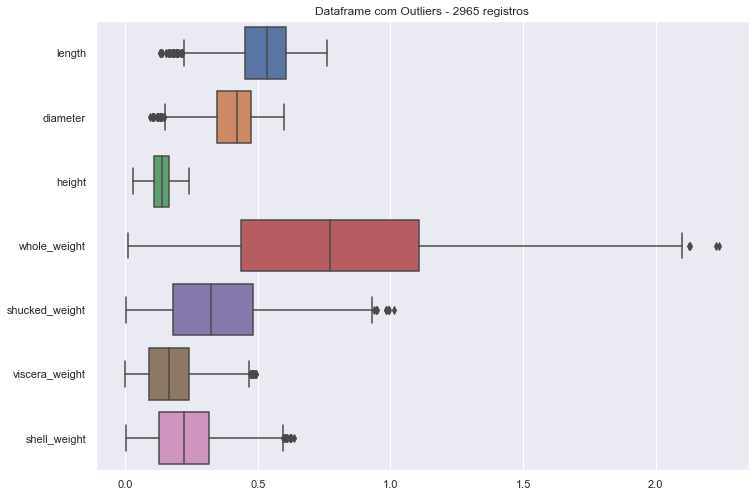

In [10]:
seaborn.boxplot(data=dataframe_[dataframe_.columns.drop(['type'])], orient='h')
p = pyplot.title('Dataframe com Outliers - %d registros' % dataframe_.shape[0])

Vamos converter a coluna `sex` para valores numéricos de acordo com a seguinte regra:

In [11]:
sex_dict = {'M': -1, 'I': 0, 'F': 1}

dataframe.sex = dataframe.sex.apply(lambda s: sex_dict[s])
dataframe_.sex = dataframe_.sex.apply(lambda s: sex_dict[s])

O modelo que iremos utilizar é o `SGDClassfier`. Como ele é sensível à escala dos dados vamos normalizar ambos os dataframes através do `StandardScaler`.

$$ x^{\prime} = \frac{x - \mu_x}{\sigma_x}$$

In [12]:
scaler = StandardScaler().fit(dataframe[dataframe.columns.drop(['type'])])
scaler_ = StandardScaler().fit(dataframe_[dataframe_.columns.drop(['type'])])

Analisando a varinância dos dados __0__ é __dataframe__ e __1__ é __dataframe___:

In [13]:
var_df = pandas.DataFrame([scaler.var_, scaler_.var_], columns=dataframe.columns.drop(['type']))
var_df

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight
0,0.663854,0.014577,0.009917,0.001537,0.239592,0.049035,0.011998,0.019375
1,0.652440,0.013498,0.009218,0.001353,0.202236,0.040196,0.010373,0.016449


Para executar o experimento vamos construir todos os subconjuntos possíveis de _features_ dos dataframes e avaliar o classificador através da validação cruzada (divide a base em 4) pela métrica da acurácia.

In [14]:
def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

Como temos $N = 8$ _features_ temos $2^N - 1 = 255$ conjuntos possíveis (exclui-se o conjunto vazio).

In [15]:
feature_subset = list(powerset(iterable=dataframe.columns.drop(['type'])))
len(feature_subset) - 1

255

In [16]:
y = dataframe.type.values
y_ = dataframe_.type.values

Vamos usar o SGDClassifier com os parâmtros definidos por padrão. Isso equivale a treinar SVM otimizando através do SGD.

In [17]:
result = []

for features in tqdm.tqdm(feature_subset[1:]):
    
    features = list(features)
    
    X = StandardScaler().fit_transform(dataframe[features])
    X_ = StandardScaler().fit_transform(dataframe_[features])

    clf = SGDClassifier(max_iter=1000, tol=1e-3)
    
    score = cross_val_score(clf, X, y, cv=4, scoring='accuracy')
    score_ = cross_val_score(clf, X_, y_, cv=4, scoring='accuracy')
    
    result.append({'mean_acc': score.mean(), 'acc_std': score.std(), 'mean_acc_': score_.mean(), 'acc_std_': score_.std(), 'features': features})

In [18]:
result_df = pandas.DataFrame(result)
result_df

,mean_acc,acc_std,mean_acc_,acc_std_,features
0,0.408046,0.053316,0.287977,0.099364,[sex]
1,0.544061,0.006697,0.559184,0.011138,[length]
2,0.555875,0.004977,0.549416,0.011312,[diameter]
3,0.556513,0.009182,0.575715,0.010253,[height]
4,0.546616,0.012867,0.544008,0.026786,[whole_weight]
...,...,...,...,...,...
250,0.633461,0.013486,0.652947,0.008807,"[sex, length, diameter, whole_weight, shucked_..."
251,0.631226,0.019586,0.640811,0.011883,"[sex, length, height, whole_weight, shucked_we..."
252,0.629310,0.019335,0.649570,0.015549,"[sex, diameter, height, whole_weight, shucked_..."
253,0.644317,0.017846,0.648899,0.014063,"[length, diameter, height, whole_weight, shuck..."


Em seguida analisamos o melhor resultado ordenando pela melhor acurácia definida por:

$${acc}_+ = {acc}_{mean} - {acc}_{std}$$


In [19]:
result_df['best_acc'] = result_df.apply(lambda row_data: row_data['mean_acc'] - row_data['acc_std'], axis=1)
result_df['best_acc_'] = result_df.apply(lambda row_data: row_data['mean_acc_'] - row_data['acc_std_'], axis=1)

Melhor acurácia dataframe com outliers

In [20]:
result_df.sort_values(by='best_acc', ascending=False)

,mean_acc,acc_std,mean_acc_,acc_std_,features,best_acc,best_acc_
216,0.644636,0.007736,0.663740,0.022252,"[diameter, whole_weight, shucked_weight, visce...",0.636900,0.641488
237,0.643359,0.007075,0.645529,0.006729,"[sex, diameter, whole_weight, shucked_weight, ...",0.636284,0.638800
239,0.646871,0.014908,0.658005,0.017176,"[length, diameter, height, whole_weight, shuck...",0.631963,0.640829
243,0.641762,0.010856,0.661717,0.013164,"[length, diameter, whole_weight, shucked_weigh...",0.630907,0.648553
217,0.636973,0.006959,0.632051,0.023802,"[height, whole_weight, shucked_weight, viscera...",0.630015,0.608249
...,...,...,...,...,...,...,...
31,0.530013,0.016205,0.569643,0.008460,"[whole_weight, viscera_weight]",0.513808,0.561183
37,0.545338,0.032698,0.583142,0.011286,"[sex, length, height]",0.512640,0.571856
12,0.513410,0.015138,0.527821,0.023342,"[sex, shucked_weight]",0.498272,0.504480
5,0.497765,0.025866,0.521757,0.007836,[shucked_weight],0.471899,0.513921


Melhor acurácia dataframe __SEM__ outliers:

In [21]:
result_df.sort_values(by='best_acc_', ascending=False)

,mean_acc,acc_std,mean_acc_,acc_std_,features,best_acc,best_acc_
224,0.626117,0.023399,0.671498,0.013750,"[sex, length, diameter, whole_weight, shucked_...",0.602718,0.657748
240,0.630268,0.007309,0.661721,0.006814,"[length, diameter, height, whole_weight, shuck...",0.622959,0.654906
207,0.637612,0.010272,0.662053,0.008132,"[length, height, whole_weight, shucked_weight,...",0.627340,0.653921
245,0.641443,0.025211,0.664414,0.011260,"[diameter, height, whole_weight, shucked_weigh...",0.616232,0.653154
232,0.626117,0.006410,0.661387,0.009537,"[sex, length, whole_weight, shucked_weight, vi...",0.619708,0.651849
...,...,...,...,...,...,...,...
112,0.548531,0.008963,0.561538,0.037114,"[sex, diameter, whole_weight, viscera_weight]",0.539569,0.524425
4,0.546616,0.012867,0.544008,0.026786,[whole_weight],0.533749,0.517222
5,0.497765,0.025866,0.521757,0.007836,[shucked_weight],0.471899,0.513921
12,0.513410,0.015138,0.527821,0.023342,"[sex, shucked_weight]",0.498272,0.504480


O melhor resultado:

In [22]:
best_result = result_df.iloc[239]

In [23]:
print('Features Selecionados %s\n' % str(best_result['features']))
print('Dataframe COM outliers')
print('Intervalo Acurácia : %.2f - %.2f\n' % (best_result['mean_acc'] - best_result['acc_std'], best_result['mean_acc'] + best_result['acc_std']))
print('Dataframe SEM outliers')
print('Intervalo Acurácia : %.2f - %.2f' % (best_result['mean_acc_'] - best_result['acc_std_'], best_result['mean_acc_'] + best_result['acc_std_']))

Features Selecionados ['length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight']

Dataframe COM outliers
Intervalo Acurácia : 0.63 - 0.66

Dataframe SEM outliers
Intervalo Acurácia : 0.64 - 0.68
